In [40]:
import pandas as pd
import numpy as np
import os
import joblib
import lightgbm as lgb
import xgboost as xgb
from tensorflow import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [41]:
# Cargar datos
train = pd.read_csv("../../data/post_cleaning/training_set.csv", parse_dates=["date"])
val = pd.read_csv("../../data/post_cleaning/validation_set.csv", parse_dates=["date"])
test_set_full = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])
# --- MODIFICACIÓN: Limitar el test set a los primeros 20 días ---
n_days_to_test = 20
test_set = test_set_full.head(n_days_to_test).copy()

X_train = train.drop(columns=["date", "target_trend"]).values
y_train = train["target_trend"].values
X_val = val.drop(columns=["date", "target_trend"]).values
y_val = val["target_trend"].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

In [42]:

# Importar la clase ModelLoader
from model_loader import ModelLoader

# Leer el archivo de métricas
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')

# Encontrar el modelo con el mayor trend_change_f1_score
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")

# Construir la ruta del archivo del modelo
model_file = f'../../score_models/{best_model_name}.txt'

# Instanciar y cargar el modelo
loader = ModelLoader(best_model_name, model_file)
model = loader.load()
params = model.params


Mejor modelo según trend_change_f1_score: LightGBM


Backtesting con Optuna:   0%|          | 0/4 [00:00<?, ?it/s][I 2025-09-03 22:58:23,417] A new study created in memory with name: no-name-763cbea7-2d84-4723-bc62-07600c33bd33
[I 2025-09-03 22:58:25,999] Trial 0 finished with value: 0.9134199134199135 and parameters: {'learning_rate': 0.030710573677773714, 'num_leaves': 97, 'max_depth': 10, 'feature_fraction': 0.8394633936788146, 'bagging_fraction': 0.6624074561769746, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: 0.9134199134199135.
[I 2025-09-03 22:58:26,540] Trial 1 finished with value: 0.9130434782608695 and parameters: {'learning_rate': 0.13394334706750485, 'num_leaves': 68, 'max_depth': 10, 'feature_fraction': 0.608233797718321, 'bagging_fraction': 0.9879639408647978, 'bagging_freq': 6, 'min_child_samples': 25}. Best is trial 0 with value: 0.9134199134199135.
[I 2025-09-03 22:58:27,414] Trial 2 finished with value: 0.908695652173913 and parameters: {'learning_rate': 0.017240892195821537, 'num_leaves': 34


--- Resultados del Backtesting (Optuna + Ventana Deslizante) ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $9,672.92
Retorno Total de la Estrategia: -3.27%
Retorno de Comprar y Mantener (Buy & Hold): -3.68%


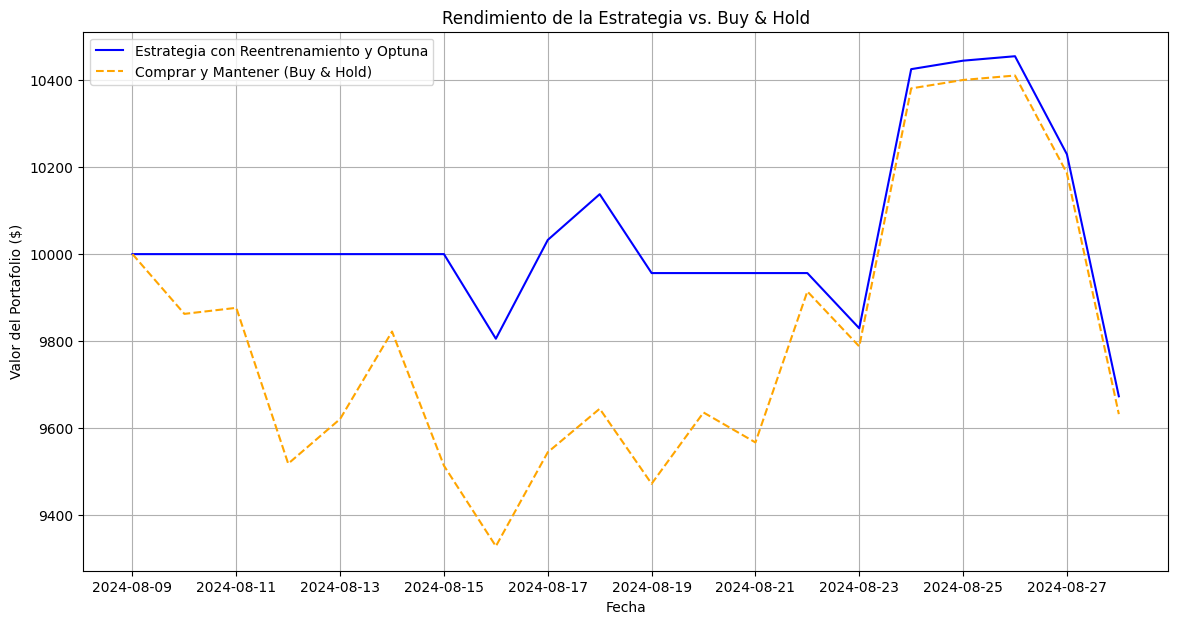

In [43]:
# --- Ejecución del Backtesting con Optimización ---
from strategy_tester import Backtesting

# 1. Configuración
initial_capital = 10000.0
window_size = 5
optuna_trials_per_step = 25 # Reducido para agilizar, ajústalo según sea necesario

# 2. Instanciar y ejecutar el backtesting
# La clase se encarga de preparar los datos y ejecutar el bucle
bt = Backtesting(
    X_train, y_train, X_val, y_val, X_test, y_test, test_set,
    window_size=window_size,
    initial_capital=initial_capital,
    optuna_trials=optuna_trials_per_step
)

# Ejecutar el método específico para LightGBM
backtest_df, price_col = bt.lightgbm()

# 3. Resultados y Visualización
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("\n--- Resultados del Backtesting (Optuna + Ventana Deslizante) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia con Reentrenamiento y Optuna', color='blue')
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

Realizando entrenamiento inicial con datos de train+val...
Entrenamiento inicial completo.


Backtesting con Reentrenamiento: 100%|██████████| 59/59 [00:31<00:00,  1.88it/s]



--- Resultados del Backtesting (Ventana Deslizante) ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $12,412.57
Retorno Total de la Estrategia: 24.13%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


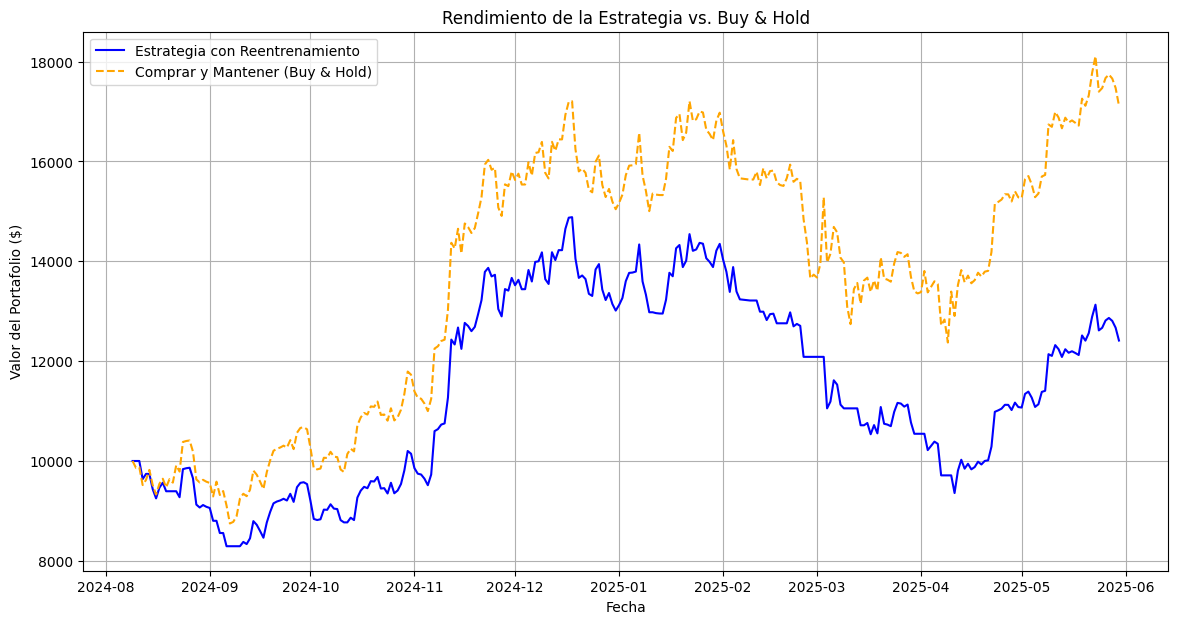

In [31]:
# --- Backtesting con Reentrenamiento en Ventana Deslizante ---

# 1. Configuración Inicial
window_size = 5
n_test = X_test.shape[0]

# Preparar datos iniciales de entrenamiento (train + val)
X_train_current = np.vstack([X_train, X_val])
y_train_current = np.concatenate([y_train, y_val])

# Mapeo de clases: (-1,0,1) -> (0,1,2)
cls_map = {-1: 0, 0: 1, 1: 2}
inv_map = {v: k for k, v in cls_map.items()}
y_train_current_m = np.vectorize(cls_map.get)(y_train_current)
y_test_m = np.vectorize(cls_map.get)(y_test)

# 2. Reentrenamiento inicial con todos los datos (train+val)
print("Realizando entrenamiento inicial con datos de train+val...")
lgb_train_current = lgb.Dataset(X_train_current, label=y_train_current_m)
model = lgb.train(params, lgb_train_current, init_model=model)
print("Entrenamiento inicial completo.")

# 3. Configuración de la Simulación de Backtesting
backtest_df = test_set.copy()
backtest_df['signal'] = 0 # Inicializar columna de señales
price_col = [col for col in test_set.columns if 'open_d0' in col][-1]

initial_capital = 10000.0
cash = initial_capital
position = 0.0
portfolio_values = []

# 4. Bucle de Backtesting con Ventana Deslizante
for start in tqdm(range(0, n_test, window_size), desc="Backtesting con Reentrenamiento"):
    end = min(start + window_size, n_test)
    
    # A. Predecir el siguiente bloque de 'window_size' días
    X_pred_block = X_test[start:end]
    y_prob_block = model.predict(X_pred_block)
    y_pred_mapped = np.argmax(y_prob_block, axis=1)
    y_pred_signals = np.vectorize(inv_map.get)(y_pred_mapped)
    
    # Guardar las señales en el DataFrame de backtesting
    backtest_df.loc[start:end-1, 'signal'] = y_pred_signals
    
    # B. Simular la estrategia para el bloque predicho
    for i in range(start, end):
        price = backtest_df.loc[i, price_col]
        signal = backtest_df.loc[i, 'signal']
        
        if signal == 1 and cash > 0:  # Comprar
            position = cash / price
            cash = 0.0
        elif signal == -1 and position > 0:  # Vender
            cash = position * price
            position = 0.0
        
        current_portfolio_value = cash + position * price
        portfolio_values.append(current_portfolio_value)

    # C. Reentrenar el modelo si no hemos llegado al final
    if end < n_test:
        # Actualizar el dataset de entrenamiento (ventana deslizante)
        X_train_current = np.vstack([X_train_current[window_size:], X_test[start:end]])
        y_train_current_m = np.concatenate([y_train_current_m[window_size:], y_test_m[start:end]])
        
        # Reentrenar
        lgb_train_current = lgb.Dataset(X_train_current, label=y_train_current_m)
        model = lgb.train(params, lgb_train_current, init_model=model)

# 5. Resultados y Visualización
backtest_df['portfolio_value'] = portfolio_values

final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("\n--- Resultados del Backtesting (Ventana Deslizante) ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia con Reentrenamiento', color='blue')
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
window_size = 5
n_test = X_test.shape[0]
y_pred_test = []

# Paso 1: Entrena con train + val
X_train_current = np.vstack([X_train, X_val])
y_train_current = np.concatenate([y_train, y_val])

# Mapear clases (-1,0,1) -> (0,1,2) para LightGBM si es necesario
# Esto es importante si tu modelo fue entrenado con clases 0,1,2
cls_map = {-1:0, 0:1, 1:2}
y_train_current_m = np.vectorize(cls_map.get)(y_train_current)
y_test_m = np.vectorize(cls_map.get)(y_test)


# Obtener los parámetros del modelo cargado
params = model.params

# Entrenar el modelo inicial
lgb_train_current = lgb.Dataset(X_train_current, label=y_train_current_m)
model = lgb.train(params, lgb_train_current, init_model=model)


for start in tqdm(range(0, n_test, window_size), desc="Backtesting"):
    end = min(start + window_size, n_test)
    
    # Paso 2: Predice los siguientes window_size días del test
    X_pred = X_test[start:end]
    y_prob = model.predict(X_pred)
    y_pred = y_prob.argmax(axis=1) # Obtener la clase con mayor probabilidad
    y_pred_test.extend(y_pred)
    print(f"Predicción del bloque {start} a {end}: {y_pred}")

    # Paso 3: Reentrena si quedan días por predecir
    if end < n_test:
        # Elimina los primeros window_size días del entrenamiento actual
        X_train_current = np.vstack([X_train_current[window_size:], X_test[start:end]])
        y_train_current_m = np.concatenate([y_train_current_m[window_size:], y_test_m[start:end]])
        
        # Reentrenar el modelo con el nuevo dataset
        lgb_train_current = lgb.Dataset(X_train_current, label=y_train_current_m)
        model = lgb.train(params, lgb_train_current, init_model=model) # Continúa el entrenamiento
        
        print(f"Reentrenamiento realizado con datos hasta el día {end}")

# Mapear las predicciones de vuelta a -1, 0, 1 si es necesario
inv_map = {v: k for k, v in cls_map.items()}
y_pred_test_orig = [inv_map[p] for p in y_pred_test]

print("Predicciones rolling window sobre el test:")
print(y_pred_test_orig)


AGREGADO POR GABRIEL

Mejor modelo según trend_change_f1_score: LightGBM


Simulación Backtesting: 100%|██████████| 295/295 [00:00<00:00, 9783.74it/s]

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $18,817.31
Retorno Total de la Estrategia: 88.17%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


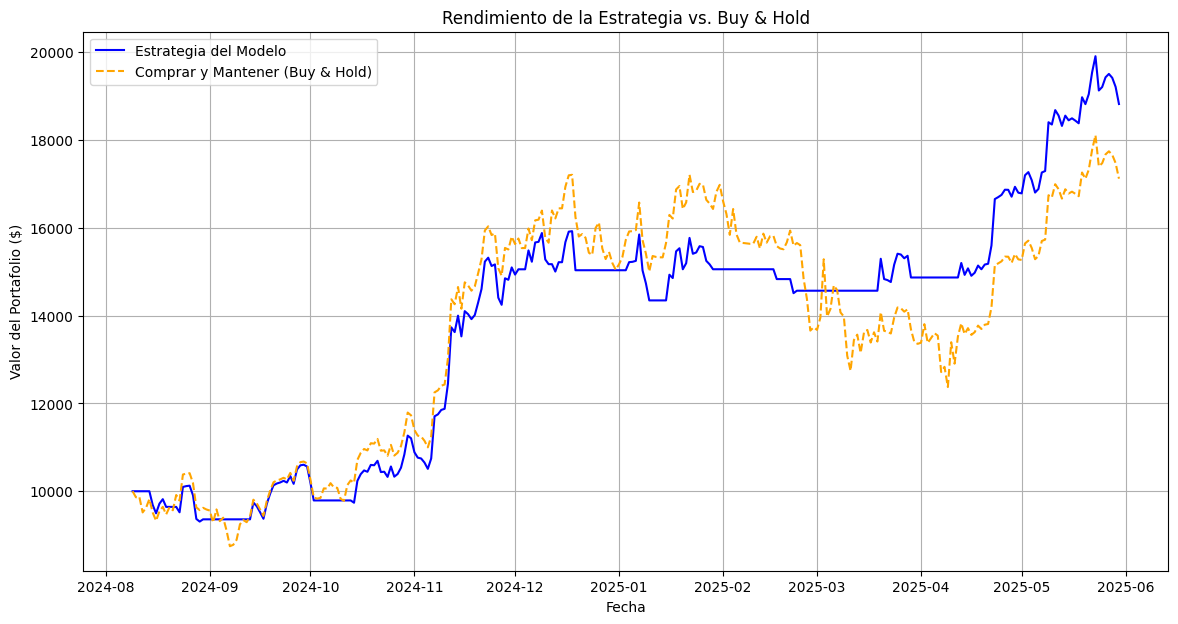

In [23]:
# Cargar datos
test_set = pd.read_csv("../../data/post_cleaning/test_set.csv", parse_dates=['date'])
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values

# Cargar el mejor modelo previamente entrenado
from model_loader import ModelLoader
metrics_path = '../../score_models/model_comparison_metrics.csv'
df = pd.read_csv(metrics_path, index_col='model')
best_model_name = df['trend_change_f1_score'].idxmax()
print(f"Mejor modelo según trend_change_f1_score: {best_model_name}")
model_file = f'../../score_models/{best_model_name}.txt'
loader = ModelLoader(best_model_name, model_file)
model = loader.load()

# Mapeo de clases para la conversión
cls_map = {-1: 0, 0: 1, 1: 2}
inv_map = {v: k for k, v in cls_map.items()}


y_pred_prob = model.predict(X_test)
y_pred_mapped = np.argmax(y_pred_prob, axis=1)
y_pred_test = np.vectorize(inv_map.get)(y_pred_mapped)


# Crear DataFrame para backtesting
backtest_df = test_set.copy()
backtest_df['signal'] = y_pred_test

# Seleccionar la columna de precio (ajusta si tu columna es diferente)
price_col = [col for col in test_set.columns if 'open_d0' in col]
if price_col:
    price_col = price_col[-1]
else:
    price_col = test_set.columns[1]  # fallback: segunda columna

# Simulación de estrategia
initial_capital = 10000.0
cash = initial_capital
position = 0.0  # Unidades de BTC
portfolio_values = []

for i, row in tqdm(backtest_df.iterrows(), total=len(backtest_df), desc="Simulación Backtesting"):
    price = row[price_col]
    signal = row['signal']
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    # Calcular el valor actual del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df['portfolio_value'] = portfolio_values

# Métricas de rendimiento
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("--- Resultados del Backtesting ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# Visualización
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')
plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

Aquí tienes el código para realizar el backtesting siguiendo el esquema de la celda 20 de multiclass_neural_network.ipynb, pero adaptado para tu flujo de selección de modelo en select_best_model.ipynb.
El código usa el modelo previamente entrenado y guardado, predice sobre el test, genera señales y simula la estrategia, mostrando métricas y gráficos comparativos.

Notas:

El código es compatible con cualquier modelo que hayas guardado y cargado con ModelLoader.
Si tu modelo de red neuronal usa mapeo inverso de clases, ajusta la línea de y_pred_test.
Cambia price_col si tu columna de precios tiene otro nombre.
Se usa tqdm para mostrar el progreso de la simulación.
¿Quieres agregar métricas adicionales o guardar los resultados?